In [9]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important; }<style>"))
pd.set_option("display.max_colwidth", -1)
pd.set_option("display.max_columns", 100)

In [48]:
data_train = pd.read_csv('./data/train.csv')
data_test = pd.read_csv('./data/test.csv')

In [49]:
data_train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
232,233,0,2,"Sjostedt, Mr. Ernst Adolf",male,59.0,0,0,237442,13.50,NaN,S
208,209,1,3,"Carr, Miss. Helen ""Ellen""",female,16.0,0,0,367231,7.75,NaN,Q
459,460,0,3,"O'Connor, Mr. Maurice",male,NaN,0,0,371060,7.75,NaN,Q


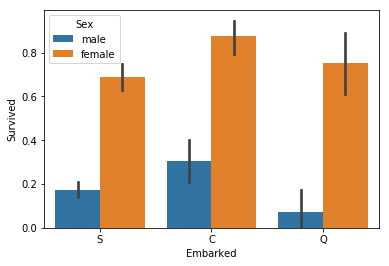

In [50]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=data_train)

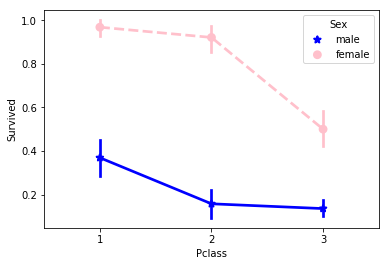

In [51]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data_train, palette={"male": "blue", "female":"pink"},markers=["*","o"],linestyles=["-", "--"])

In [52]:
def simplify_ages(df):
    df['Age'] = df['Age'].fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 
                  'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df['Age'], bins, labels = group_names)
    df['Age'] = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df

def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

In [53]:
def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

In [54]:
data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


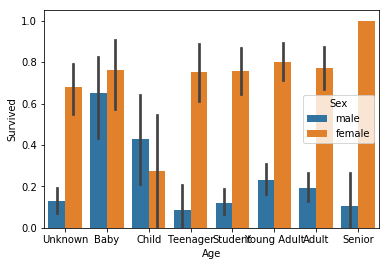

In [55]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=data_train)

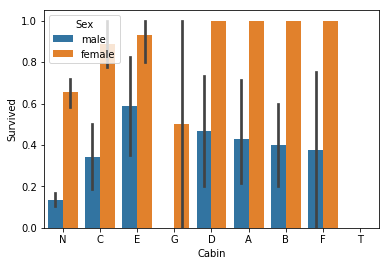

In [56]:
sns.barplot(x="Cabin", y="Survived", hue="Sex", data=data_train)

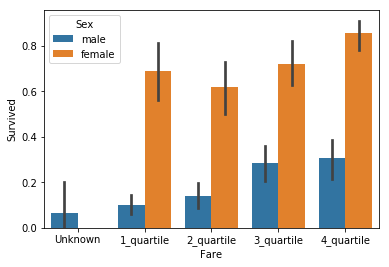

In [57]:
sns.barplot(x="Fare", y="Survived", hue="Sex", data=data_train)

In [58]:
from sklearn import preprocessing

In [59]:
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
        
    return df_train, df_test

data_train, data_test = encode_features(data_train, data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


In [60]:
from sklearn.model_selection import train_test_split

In [61]:
X_all = data_train.drop(['Survived', 'PassengerId'], axis = 1)
y_all = data_train['Survived']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state = 23)

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(clf, parameters, scoring = acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

clf = grid_obj.best_estimator_

clf.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=9,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [63]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.8491620111731844


In [67]:
from sklearn.model_selection import KFold

In [72]:
def run_kfold(clf):
    kf = KFold(len(data_train['Age']), n_splits=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome))

run_kfold(clf)

TypeError: __init__() got multiple values for argument 'n_splits'

In [74]:
ids = data_test['PassengerId']
predictions = clf.predict(data_test.drop('PassengerId', axis = 1))

output = pd.DataFrame({ 'PassengerID' : ids, 'Survived':predictions})

output.head()

,PassengerID,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
